### 1. Research Problem {-}

__1.1. Description__

Astronomy is the study of everything in the universe beyond Earth's atmosphere. Astronomers use stellar classification to classify stars based on spectral characteristics. Spectral characteristics help astronomers extract more information about the stars - elements, temperature, density, and magnetic field. The classification scheme of galaxies, quasars, and stars is one of the most fundamental in astronomy. This problem aims to classify stars, galaxies, and quasars (luminous supermassive black holes) based on their spectral characteristics.

__1.2. Research objectives and constraints__

1. No low-latency requirement.
2. Interpretability is important.
3. Errors can be very costly.
4. Probability of a datapoint belonging to each class is needed.

---

### 2. Machine Learning Problem Formulation {-}

__2.1. Data overview__

The data consists of 100,000 observations of space taken by the __SDSS__ (Sloan Digital Sky Survey). Every observation is described by $17$ feature columns and $1$ class column which identifies it to be either a __star__, __galaxy__, or __quasar__ [1].

Features in the dataset:

1. `obj_ID` = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS.
2. `alpha` = Right Ascension angle (at J2000 epoch).
3. `delta` = Declination angle (at J2000 epoch).
4. `u` = Ultraviolet filter in the photometric system.
5. `g` = Green filter in the photometric system.
6. `r` = Red filter in the photometric system.
7. `i` = Near Infrared filter in the photometric system.
8. `z` = Infrared filter in the photometric system.
9. `run_ID` = Run Number used to identify the specific scan.
10. `rereun_ID` = Rerun Number to specify how the image was processed.
11. `cam_col` = Camera column to identify the scanline within the run.
12. `field_ID` = Field number to identify each field.
13. `spec_obj_ID` = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same `spec_obj_ID` must share the output class).
14. `class` = Object class (galaxy, star or quasar object).
15. `redshift` = Redshift value based on the increase in wavelength.
16. `plate` = Plate ID, identifies each plate in SDSS.
17. `MJD` = Modified Julian Date, used to indicate when a given piece of SDSS data was taken.
18. `fiber_ID` = Fiber ID that identifies the fiber that pointed the light at the focal plane in each observation.

__2.2 Background information useful to understand the data__

2.2.1. Celestial sphere

The celestial sphere is an imaginary sphere that has large radius and is concentric to Earth. All objects in the sky can be conceived as being projected upon the inner surface of the celestial sphere, which may be centered on Earth or the observer [2].

2.2.2. Celestial equator

The celestial equator is the great circle of the imaginary celestial sphere on the same plane as the equator of Earth [3].

2.2.3. Ascension and declination

Ascension and declination both are used in astronomy and navigation in space. Ascension tells _how far left or right the object is in celestial sphere_ and declination tells _how far up or down the object is in celestial sphere_ [4].

2.2.4. Photometric system

The word _photo_ means _light_ and _metry_ means _measurement_. So, measuring the brightness of light which a human eye can perceive is called photometry.

The UBV photometric system (from Ultraviolet, Blue, Visual), also called the Johnson system, is a photometric system usually employed for __classifying stars__ according to their colors. It was the first standardized photometric system [5, 6].

2.2.6. Redshift

Red shift is a key concept for astronomers. The term can be understood literally - the wavelength of the light is stretched, so the light is seen as 'shifted' towards the red part of the spectrum. It reveals how an object in space (star/planet/galaxy) is moving compared to us. It lets astronomers measure a distance for the most distant (and therefore oldest) objects in our universe [7].

__2.3. Mapping the research problem to a machine learning problem__

2.3.1. Type of machine learning problem

This is a multi-class classification problem as this dataset has $3$ different target classes.

2.3.2. Performance metrics

1. Multi-class logloss
2. Confusion matrix

2.3.3. Machine learing objectives and constraints

Objective:

Predict the probability of each datapoint belonging to each of the $3$ classes.

Constraints:

- Interpretability.
- Class probabilities are needed.
- Penalize the errors in class probabilites.
- No latency constraints.

---

### 3. Exploratory Data Analysis {-}

__3.1. Packages__

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import display

In [3]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-deep')

In [4]:
from tabulate import tabulate

In [5]:
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

__3.2. Data__

In [6]:
data_df = pd.read_csv(filepath_or_buffer='./data/star_classification.csv')

Metadata of the dataset.

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [8]:
print("The shape of the dataset: {}".format(data_df.shape))

The shape of the dataset: (100000, 18)


Class distribution of the dataset.

In [9]:
labels = data_df['class'].unique()
print(labels)

['GALAXY' 'QSO' 'STAR']


In [10]:
def class_distribution(df, target, classes=labels):
    """
    This function plots the distribution of given data[label].
    
    Parameters
    ----------
    `df`: dataset
    `label`: target name in the dataset
    
    Returns none.
    """
    class_df = df[target].value_counts().to_frame()
    pers = class_df.apply(lambda x: round((x / df.shape[0]) * 100, 2))
    class_df['Percentage'] = pers
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    bars = sns.barplot(x=class_df.index, y=class_df[target])
    for b in bars.patches:
        x = b.get_x() + (b.get_width() / 2)
        y = b.get_height()
        bars.annotate(text=format(y),
                      xy=(x, y), ha='center', va='center', size=8, 
                      xytext=(0, 6), textcoords='offset points')
    plt.title(label='Class Distribution', fontsize=10)
    
    plt.subplot(122)
    plt.pie(x=class_df['Percentage'].values,
            labels=labels,
            autopct='%1.1f%%')
    plt.title(label='Class Proportion', fontsize=10)
    plt.show()

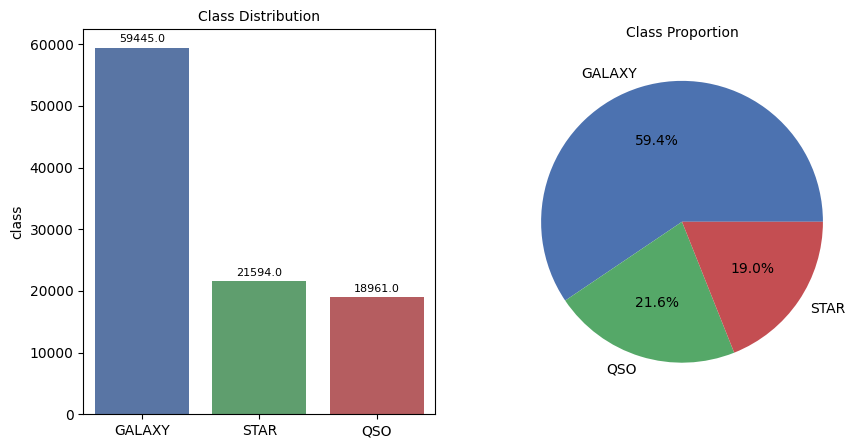

In [11]:
class_distribution(df=data_df, target='class')

From the above distribution and proportion plots, I see that the dataset is not balanced across the target variable.

Checking for `NULL` values in the dataset.

In [12]:
display(data_df.isnull().sum())

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

This dataset has zero NULL values.

__3.3. Selecting important features from domain understanding__

From section 2.2, I understand that some features in the dataset are significantly useful such as: navigation angles - _ascension_ and _declination_, filters of the photometric system - _u_, _g_, _r_, _i_, _z_, and _redshift_. All other columns in the dataset are IDs.

In [13]:
imp_cols = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']

Basic statistics on selected columns.

In [14]:
display(data_df[imp_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
alpha,100000.0,177.629117,96.502241,0.005528,127.518222,180.900700,233.895005,359.999810
delta,100000.0,24.135305,19.644665,-18.785328,5.146771,23.645922,39.901550,83.000519
u,100000.0,21.980468,31.769291,-9999.000000,20.352353,22.179135,23.687440,32.781390
g,100000.0,20.531387,31.750292,-9999.000000,18.965230,21.099835,22.123767,31.602240
r,100000.0,19.645762,1.854760,9.822070,18.135828,20.125290,21.044785,29.571860
i,100000.0,19.084854,1.757895,9.469903,17.732285,19.405145,20.396495,32.141470
z,100000.0,18.668810,31.728152,-9999.000000,17.460677,19.004595,19.921120,29.383740
redshift,100000.0,0.576661,0.730707,-0.009971,0.054517,0.424173,0.704154,7.011245


__3.4. Boxplots for univariate analysis__

In [15]:
def box_plotter(df, features, target):
    """
    This is funtion helps in plotting the boxplot of data.
    
    Parameters
    ----------
    `df`: dataset
    `features`: columns for analysis
    `target`: target column name
    
    Returns none.
    """
    plt.figure(figsize=(15, 30))
    for (i, feature) in zip(range(len(features)), features):
        plt.subplot(int('{}2{}'.format(len(features), i+1)))
        sns.boxplot(x=target, y=feature, data=df,
                    width=0.5, flierprops={'marker': 'x'})
        plt.title(label='Boxplot of {}'.format(feature), fontsize=10)
        plt.xlabel(xlabel=None)
        plt.ylabel(ylabel=None)
        i += 1
    plt.show()

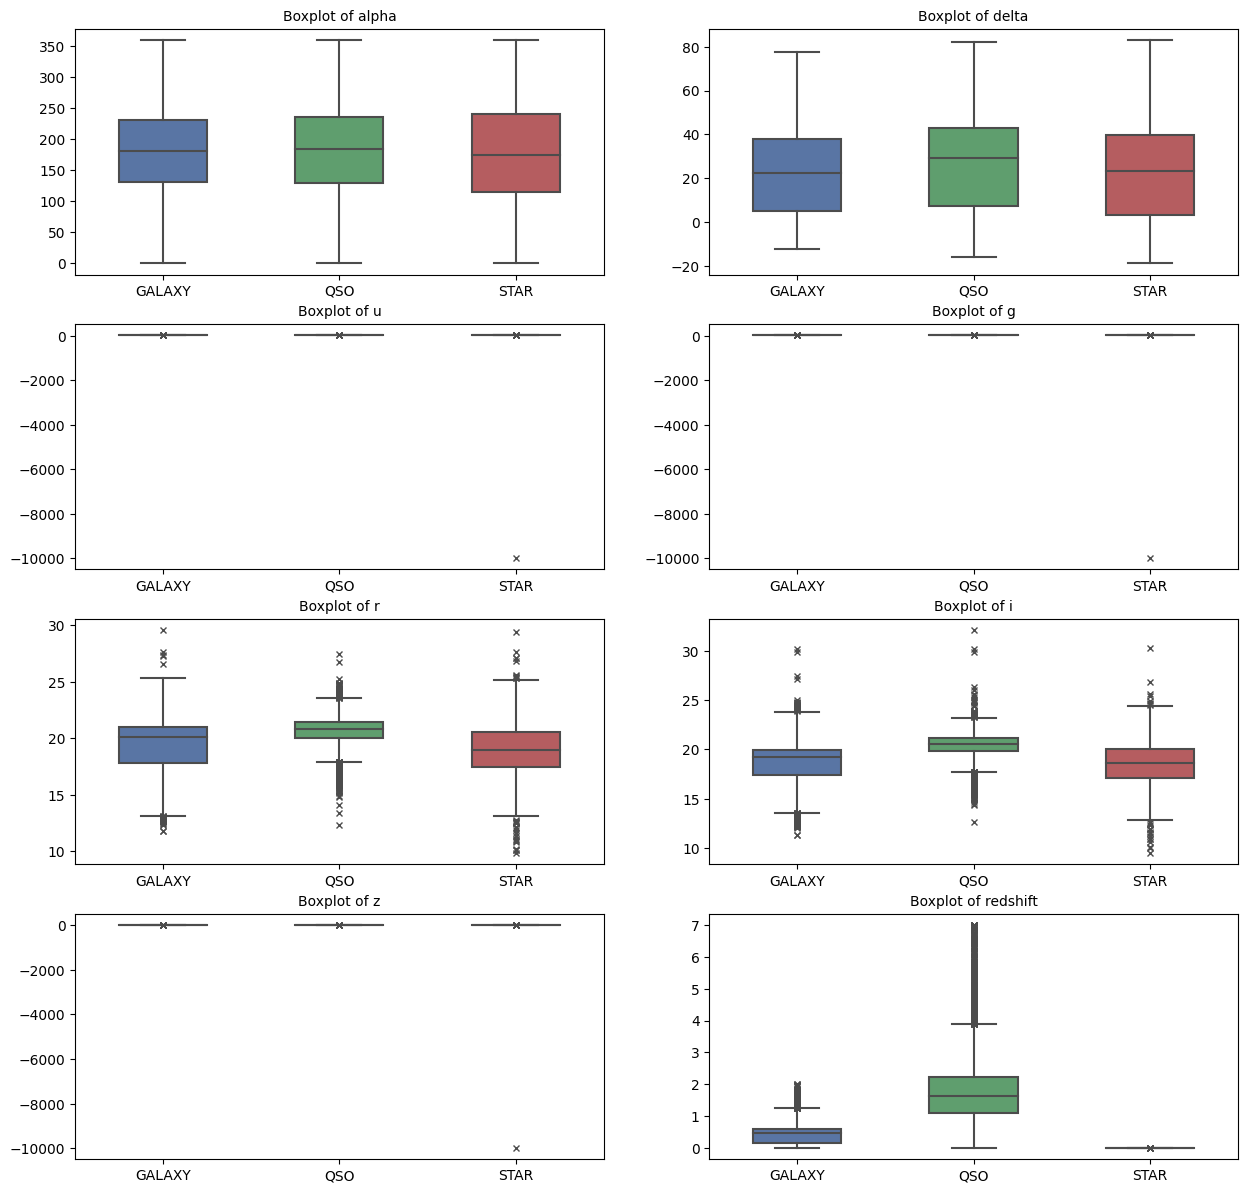

In [16]:
box_plotter(df=data_df, features=imp_cols, target='class')

From the above boxplots, it is clear that columns - _u_, _g_, and _z_ have one outlier value that belongs to the __STAR__ class. The outlier value is located in the $79543$ index of the dataset.

In [17]:
display(data_df[data_df['u'] == min(data_df['u'])][imp_cols + ['class']])

,alpha,delta,u,g,r,i,z,redshift,class
79543,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,0.000089,STAR


In [18]:
display(data_df[data_df['g'] == min(data_df['g'])][imp_cols + ['class']])

,alpha,delta,u,g,r,i,z,redshift,class
79543,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,0.000089,STAR


In [19]:
display(data_df[data_df['z'] == min(data_df['z'])][imp_cols + ['class']])

,alpha,delta,u,g,r,i,z,redshift,class
79543,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,0.000089,STAR


Removing the outlier index from the dataset.

In [20]:
data_df = data_df.drop(index=[79543])
print("The shape of the dataset: {}".format(data_df.shape))

The shape of the dataset: (99999, 18)


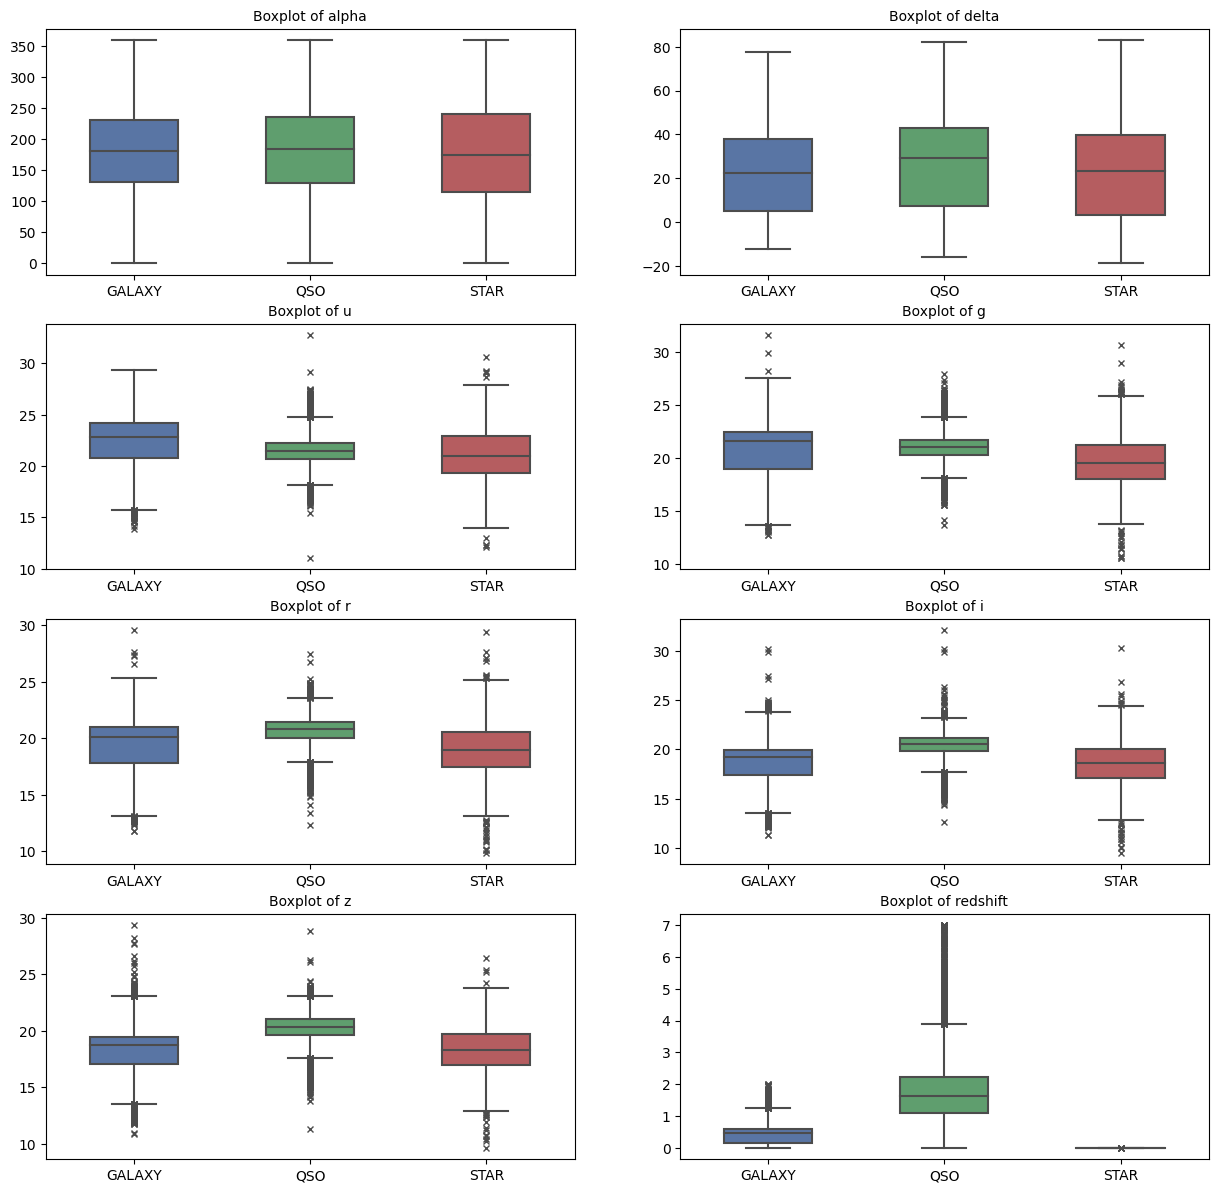

In [21]:
box_plotter(df=data_df, features=imp_cols, target='class')

The boxplot of the columns - _u_, _g_, and _z_, looks better as I removed the outlier value from the dataset. However, when I observe the box plot of the _redshift_ column, I see that the redshift values for the __STAR__ class are almost $0$.

__3.5. PDF plots for univariate analysis__

In [22]:
def pdf_plotter(df, features, target):
    """
    This is funtion helps in plotting the pdf of data.
    
    Parameters
    ----------
    `df`: dataset
    `features`: columns for analysis
    `target`: target column name
    
    Returns none.
    """
    plt.figure(figsize=(15, 30))
    for (i, feature) in zip(range(len(features)), features):
        plt.subplot(int('{}2{}'.format(len(features), i+1)))
        sns.kdeplot(data=df, x=feature, hue=target, shade=True)
        plt.title(label='PDF of {}'.format(feature), fontsize=10)
        plt.xlabel(xlabel='')
        plt.grid()
        i += 1
    plt.show()

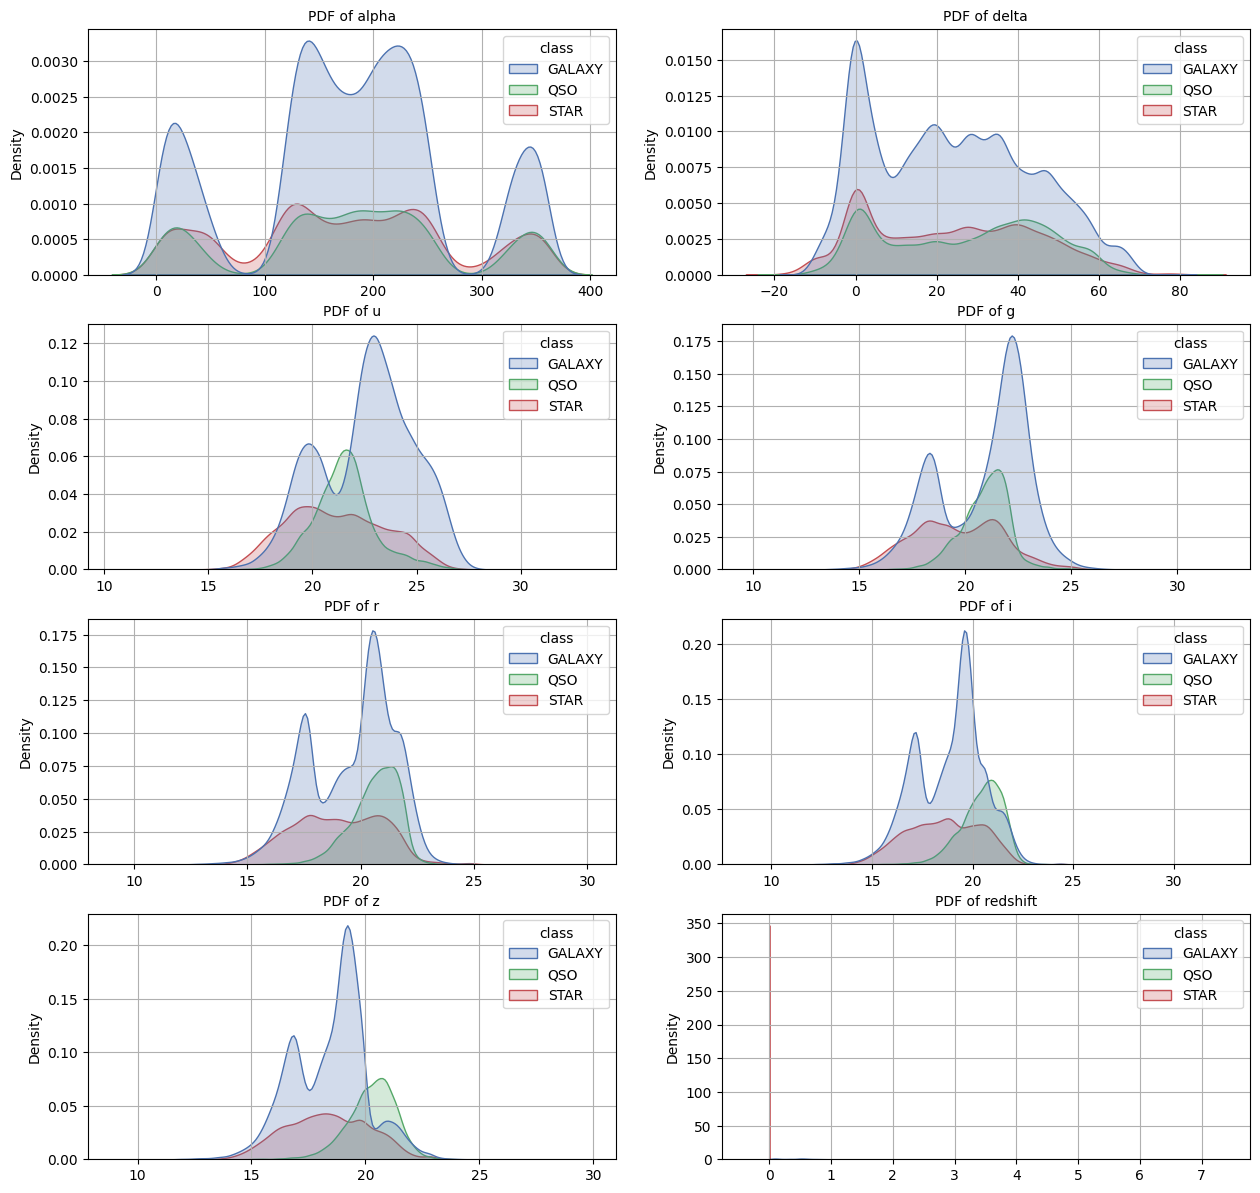

In [23]:
pdf_plotter(df=data_df, features=imp_cols, target='class')

From the above density plots, I see that the density of all columns is overlapping, except for the _redshift_ column. In the density plot of the _redshift_ column, the __STAR__ class has all $0$ values. The kernel density plots of the columns do not follow the Gaussian distribution.

__3.6. Pairplots for multivariate analysis__

Pairplot and correlation plot for columns - _alpha_, _delta_, and _redshift_.

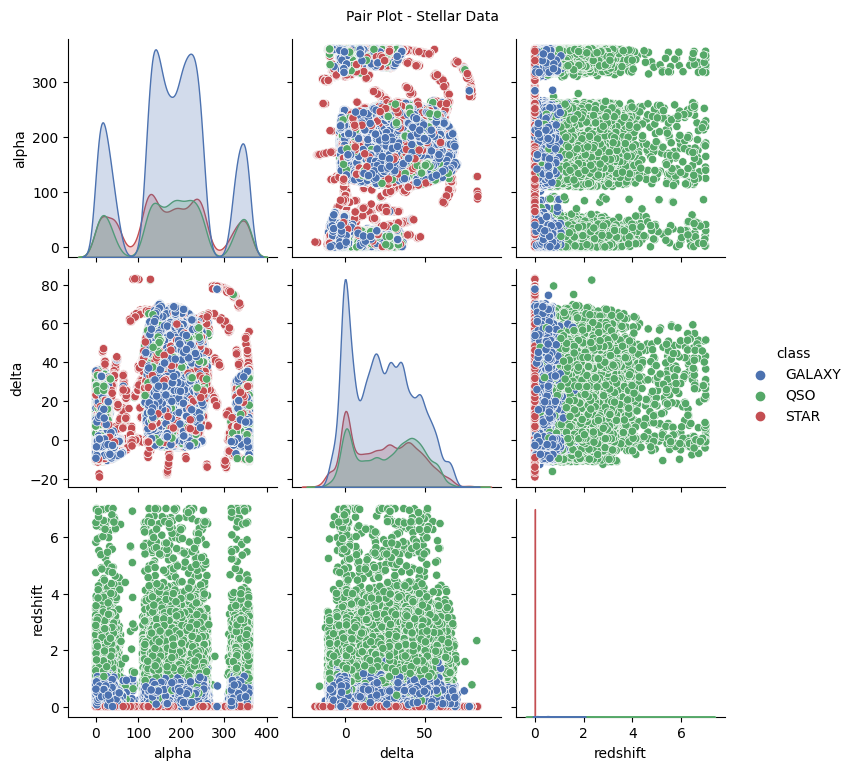

In [24]:
g = sns.pairplot(data=data_df[['alpha', 'delta', 'redshift', 'class']],
                 hue='class')
g.fig.suptitle(t='Pair Plot - Stellar Data', y=1.02, fontsize=10)
plt.show()

Clearly, I cannot see any correlation in the above pairplot for the columns - _alpha_, _delta_ and _redshift_.

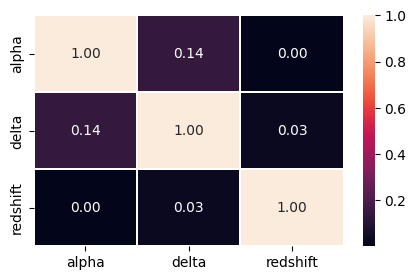

In [25]:
plt.figure(figsize=(5, 3))
sns.heatmap(data=data_df[['alpha', 'delta', 'redshift']].corr(),
            annot=True, fmt='.2f', linewidths=0.1)
plt.show()

Pairplot and correlation plot for photometric filter columns - _u_, _g_, _r_, _i_, _z_.

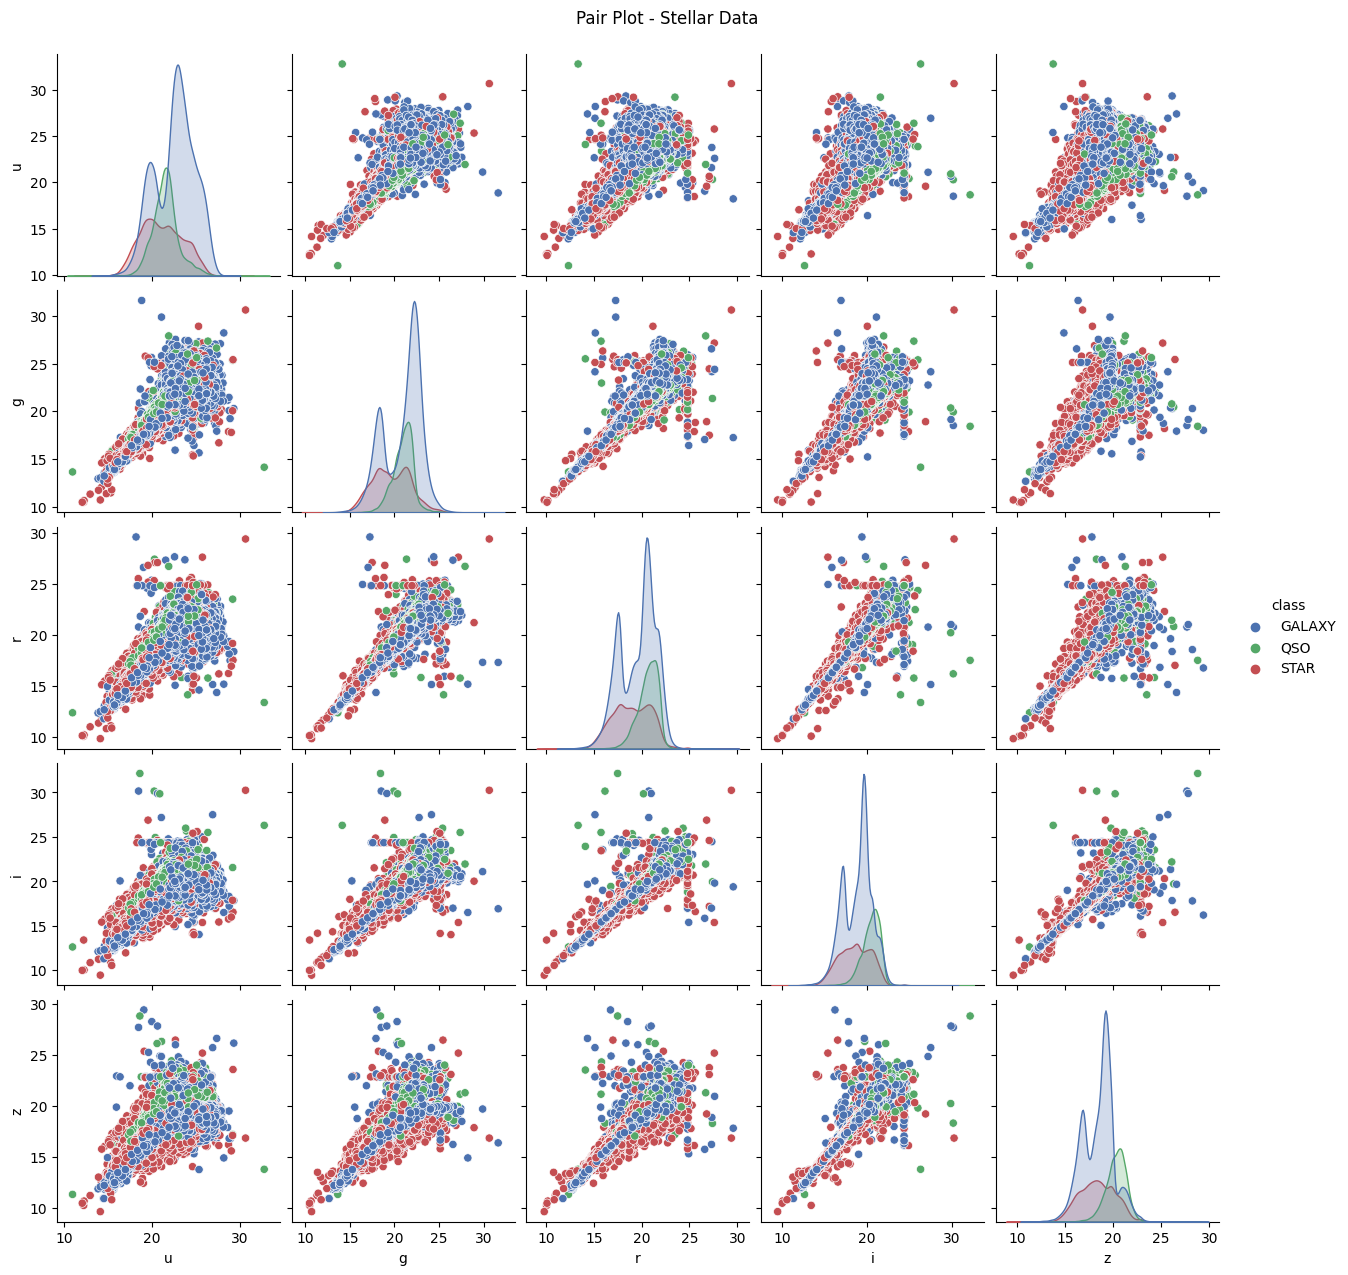

In [26]:
g = sns.pairplot(data=data_df[['u', 'g', 'r', 'i', 'z', 'class']], hue='class')
g.fig.suptitle(t='Pair Plot - Stellar Data', y=1.02)
plt.show()

There is a positive correlation among the photometric filter columns - _u_, _g_, _r_, _i_, _z_.

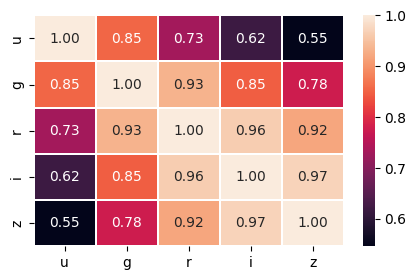

In [27]:
plt.figure(figsize=(5, 3))
sns.heatmap(data=data_df[['u', 'g', 'r', 'i', 'z']].corr(),
            annot=True, fmt='.2f', linewidths=0.1)
plt.show()

__3.7. t-SNE for multivariate analysis__

T-distributed Stochastic Neighbor Embedding. It is a tool to _visualize_ high-dimensional data, it is a dimensionality reduction technique.

In [28]:
from sklearn.manifold import TSNE

In [29]:
def plot_tSNE(df, features, target, p_list, labels=labels):
    """
    Plots the t-SNE.
    
    Parameters
    ----------
    `df`: dataset
    `features`: columns for analysis
    `target`: target column name
    `p_list`: perplexity list
    `labels`: unique target values
    
    Returns none.
    """
    
    analysis = './analysis_dumps'
    
    target_dict = {'GALAXY': 1, 'QSO': 2, 'STAR': 3}
    X = df[features].values
    y = df[target].replace(to_replace=target_dict).values
    
    plt.figure(figsize=(15, 30))
    
    for (i, p) in zip(range(len(p_list)), p_list):
        tSNE_name = 'tSNE_{}.pkl'.format(p)
        tSNE_path = os.path.join(analysis, tSNE_name)

        xtSNE = TSNE(perplexity=p)

        if not os.path.isfile(path=tSNE_path):
            xtSNE_result = xtSNE.fit_transform(X=X)

            with open(file=tSNE_path, mode='wb') as m_pkl:
                pickle.dump(obj=xtSNE_result, file=m_pkl)
        else:
            with open(file=tSNE_path, mode='rb') as m_pkl:
                xtSNE_result = pickle.load(file=m_pkl)

        vis_x = xtSNE_result[:, 0]
        vis_y = xtSNE_result[:, 1]

        plt.subplot(int('{}2{}'.format(len(features), i+1)))
        plt.scatter(x=vis_x, y=vis_y, c=y)
        plt.title(label='tSNE Perplexity: {}'.format(p), fontsize=10)
        plt.colorbar()
        plt.clim(vmin=1, vmax=len(labels))
        i += 1
    
    plt.show()

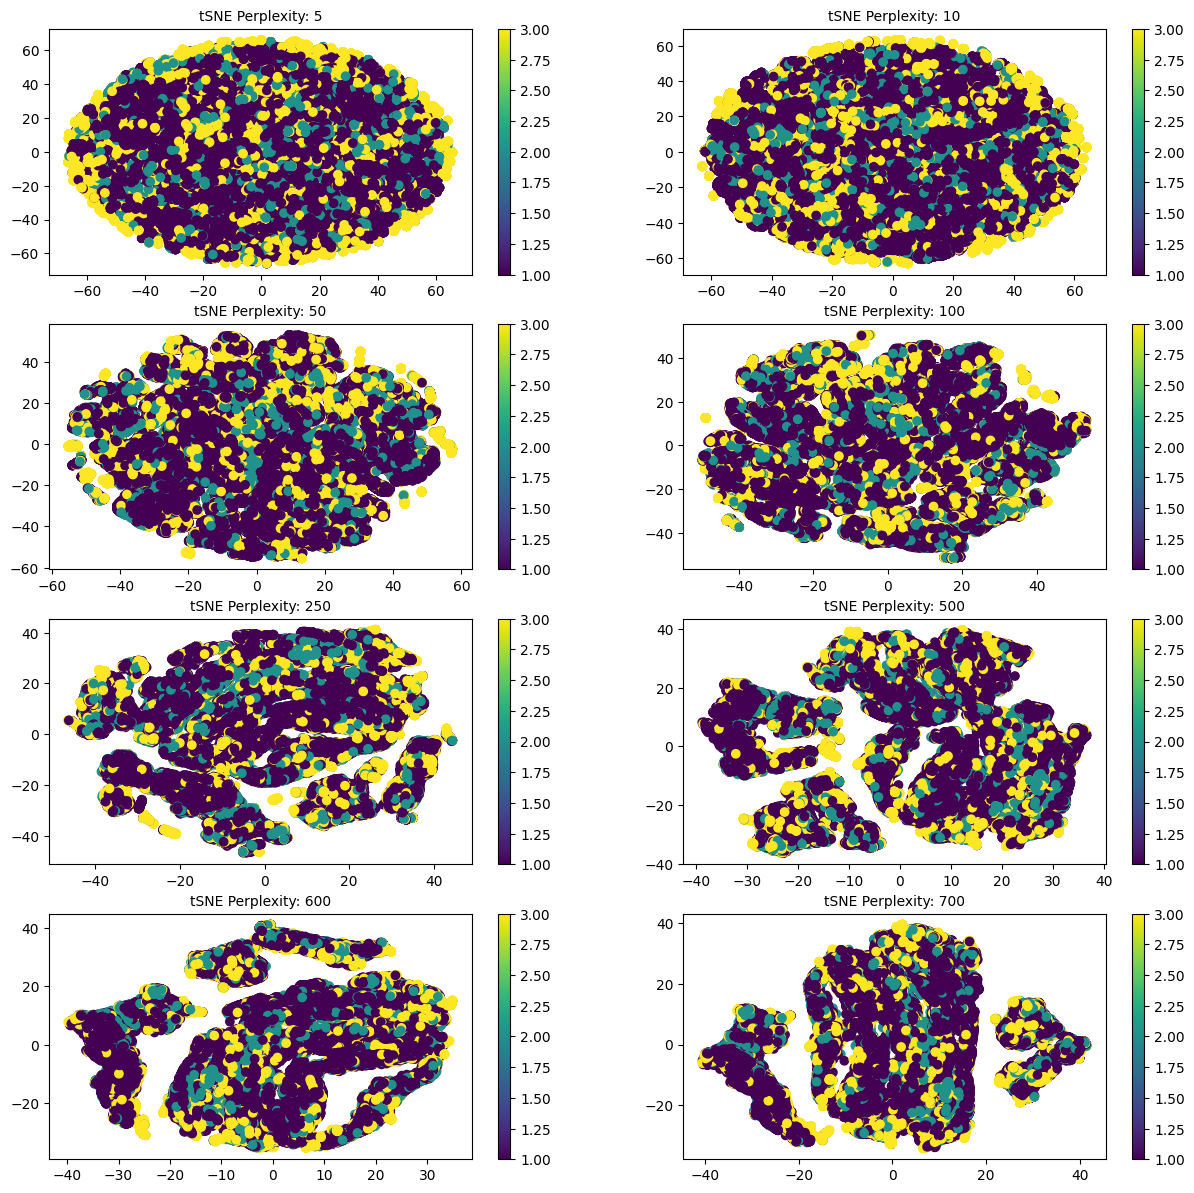

In [30]:
p_list = [5, 10, 50, 100, 250, 500, 600, 700]

plot_tSNE(df=data_df,
          features=imp_cols,
          target='class',
          p_list=p_list)

---

### 4. Feature engineering and feature importance {-}

__4.1. Data splitting__

I will split the dataset into 3 sets - Train, Cross validation, and Test sets. This is a good practice to test the model's performance before deploying it in the production.

- Train set will have $60\%$ of the data.
- Cross validation set will have $20\%$ of the data.
- Test set will have $20\%$ of the data.

In [31]:
imp_cols = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']

In [32]:
X = data_df[imp_cols]
y = data_df['class'].values

In [33]:
print(X.columns)
print("The shape of X: {}".format(X.shape))
print("The shape of y: {}".format(y.shape))

Index(['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift'], dtype='object')
The shape of X: (99999, 8)
The shape of y: (99999,)


In [34]:
from sklearn.model_selection import train_test_split

As the dataset I have currently is imbalanced, I need to split the dataset by applying _stratified sampling_ which keeps the diversity of target variable intact.

In [35]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X, y,
                            stratify=y, test_size=0.20, random_state=0)

In [36]:
(X_train,
 X_cv,
 y_train,
 y_cv) = train_test_split(X_train, y_train,
                          stratify=y_train, test_size=0.20, random_state=0)

In [37]:
print("The shape of X_train dataset: {}".format(X_train.shape))
print("The shape of X_cv dataset: {}".format(X_cv.shape))
print("The shape of X_test dataset: {}".format(X_test.shape))

The shape of X_train dataset: (63999, 8)
The shape of X_cv dataset: (16000, 8)
The shape of X_test dataset: (20000, 8)


In [38]:
print("The shape of y_train dataset: {}".format(y_train.shape))
print("The shape of y_cv dataset: {}".format(y_cv.shape))
print("The shape of y_test dataset: {}".format(y_test.shape))

The shape of y_train dataset: (63999,)
The shape of y_cv dataset: (16000,)
The shape of y_test dataset: (20000,)


__4.2. Feature engineering__

Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms. Feature engineering can be considered as applied machine learning itself [8].

4.2.1. Data normalization

The kernel density plots of the columns do not follow Gaussian distibution and moreover the columns are not having consistent scale. It is important to bring the values of all the columns into a consistent scale without distorting the meaning of the values. 

In [39]:
from sklearn.preprocessing import MinMaxScaler

In [40]:
scaling = MinMaxScaler()

In [41]:
X_train = scaling.fit_transform(X=X_train)
X_cv = scaling.transform(X=X_cv)
X_test = scaling.transform(X=X_test)

4.2.2. Values within the same band

The dataset has photometric filters - _u_, _g_, _r_, _i_, _z_ [6].

* Ultraviolet band: _u_.
    * u: ultraviolet filter
* Visible band: _g_, _r_.
    * g: green filter
    * r: red filter
* Near-Infrared: _i_, _z_.
    * i, z: infrared filters

I tried multiplying the values of the filters that belong to same category as mentioned above, but it did not yield better results. In the dataset, there is a column called _redshift_ which tallks about light stretching towards the red part of the spectrum. Hence I tried substracting the filter values of _r_ column. This improved the performance of the logistic regression model to some extent.

I also noted that columns - _alpha_ and _delta_ that imply to ascension and declination respectively do not contribute anything to model's performance.

In [42]:
def make_dataframe(arr, cols):
    """
    This function builts the dataframe.
    
    Parameters
    ----------
    `arr`: array of 2 dimension
    `cols`: column names
    
    Returns a dataframe.
    """
    df = pd.DataFrame(data=arr, columns=cols)
    return df

In [43]:
train_df_fea = make_dataframe(arr=X_train, cols=imp_cols)
cv_df_fea = make_dataframe(arr=X_cv, cols=imp_cols)
test_df_fea = make_dataframe(arr=X_test, cols=imp_cols)

In [44]:
def featurize(df):
    """
    This function featurizes the dataframe.
    
    Parameter
    ---------
    `df`: dataframe
    
    Returns a dataframe.
    """
    df['g-r'] = df['g'] - df['r']
    df['i-z'] = df['i'] - df['z']
    df['u-r'] = df['u'] - df['r']
    df['i-r'] = df['i'] - df['r']
    df['z-r'] = df['z'] - df['r']
    return df

In [45]:
train_df_fea = featurize(df=train_df_fea)
cv_df_fea = featurize(df=cv_df_fea)
test_df_fea = featurize(df=test_df_fea)

In [46]:
fea_cols = ['u', 'g', 'r', 'redshift', 'g-r', 'i-z', 'u-r', 'i-r', 'z-r']
print(fea_cols)

['u', 'g', 'r', 'redshift', 'g-r', 'i-z', 'u-r', 'i-r', 'z-r']


In [47]:
X_train_fea = train_df_fea[fea_cols].values
X_cv_fea = cv_df_fea[fea_cols].values
X_test_fea = test_df_fea[fea_cols].values

4.2.3. Principal component analysis (PCA)

PCA is a dimensionality reduction that identifies important relationships in the data, transforms the existing data based on these relationships, and then quantifies the importance of these relationships that can be used for modeling.

In [48]:
from sklearn.decomposition import PCA

In [49]:
cols_for_pca = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']

In [50]:
train_df_for_pca = train_df_fea[cols_for_pca]
cv_df_for_pca = cv_df_fea[cols_for_pca]
test_df_for_pca = test_df_fea[cols_for_pca]

In [51]:
pca_decomposer = PCA(n_components=0.95)

In [52]:
train_df_after_pca = pca_decomposer.fit_transform(X=train_df_for_pca)
cv_df_after_pca = pca_decomposer.transform(X=cv_df_for_pca)
test_df_after_pca = pca_decomposer.transform(X=test_df_for_pca)

In [53]:
pca_cols = ['f{}'.format(i+1) for i in range(train_df_after_pca.shape[1])]
print(pca_cols)

['f1', 'f2', 'f3', 'f4']


In [54]:
train_df_after_pca = make_dataframe(arr=train_df_after_pca, cols=pca_cols)
cv_df_after_pca = make_dataframe(arr=cv_df_after_pca, cols=pca_cols)
test_df_after_pca = make_dataframe(arr=test_df_after_pca, cols=pca_cols)

In [55]:
def scree_plotter(decomposer):
    """
    Draws the scree plot.
    
    Parameter
    ---------
    `decomposer`: pca object
    
    Returns none.
    """
    x_ = np.arange(pca_decomposer.n_components_)
    y = pca_decomposer.explained_variance_ratio_
    cum_y = np.cumsum(a=y)
    
    plt.figure(figsize=(7, 5))
    bars = sns.barplot(x=x_, y=cum_y)
    for b in bars.patches:
        x = b.get_x() + (b.get_width() / 2)
        y = np.round(b.get_height(), 3)
        bars.annotate(text=format(y),
                      xy=(x, y), ha='center', va='center', size=8, 
                      xytext=(0, 6), textcoords='offset points')
    plt.title('Scree Plot', fontsize=10)
    plt.xlabel('Principal Components', fontsize=9)
    plt.ylabel('Cumulative Variance Explained', fontsize=9)
    plt.xticks(ticks=x_)
    plt.show()

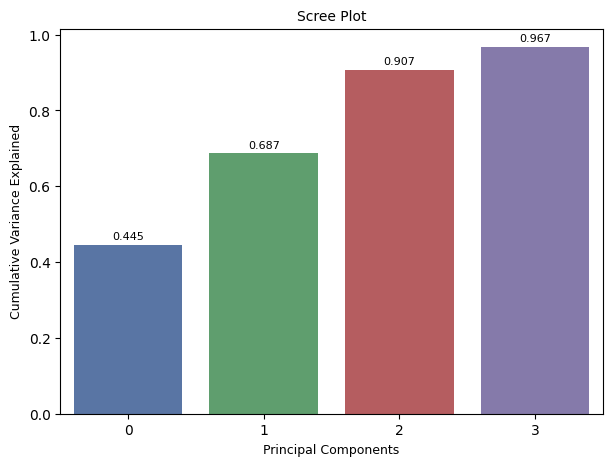

In [56]:
scree_plotter(decomposer=pca_decomposer)

In [57]:
X_train_pca = train_df_after_pca.values
X_cv_pca = cv_df_after_pca.values
X_test_pca = test_df_after_pca.values

__4.3. Confusion, Precision, and Recall matrices__

In [58]:
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             log_loss,
                             precision_score,
                             recall_score)

In [59]:
def plot_heatmap(matrix, title, labels):
    """
    This function plots the heatmap.
    
    Parameters
    ----------
    `matrix`: 2D array
    `title`: title
    `labels`: integer encoded target values
    
    Returns none.
    """
    sns.heatmap(data=matrix, annot=True, fmt='.2f', linewidths=0.1,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel(xlabel='Predicted Class')
    plt.ylabel(ylabel='Actual Class')
    plt.title(label=title, fontsize=10)

In [60]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    This function plots:
        1. Confusion matrix
        2. Precision matrix
        3. Recall matrix
    
    Parameters
    ----------
    `y_true`: ground truth (or actual) values
    `y_pred`: predicted values
    `labels`: integer encoded target values
    
    Returns none.
    """
    cmat = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
    pmat = cmat / cmat.sum(axis=0)
    print("Column sum of precision matrix: {}".format(pmat.sum(axis=0)))
    rmat = ((cmat.T) / (cmat.sum(axis=1).T)).T
    print("Row sum of recall matrix:       {}".format(rmat.sum(axis=1)))
    
    plt.figure(figsize=(15, 3))
    plt.subplot(131)
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plt.subplot(132)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plt.subplot(133)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)
    plt.show()

__4.4. Logistic Regression__

In [61]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

In [62]:
def logistic_regresson(X_train,
                       X_cv,
                       X_test,
                       y_train,
                       y_cv,
                       y_test,
                       c_params,
                       cols,
                       model_name,
                       labels=labels):
    """
    This function builds the model.
    """
    if os.path.isdir('./model_dumps/eda_models'):
        pass
    else:
        os.mkdir(path='./model_dumps/eda_models')
    
    model_path = os.path.join('./model_dumps/eda_models', model_name)

    if not os.path.isfile(path=model_path):
        log_error_list = list()
        loss_df = pd.DataFrame()

        for c_i in c_params:
            clf = LogisticRegression(C=c_i, n_jobs=-1, random_state=42,
                                     max_iter=1000)
            clf.fit(X=X_train, y=y_train)

            sig_clf = CalibratedClassifierCV(base_estimator=clf)
            sig_clf.fit(X=X_train, y=y_train)

            cv_pred = sig_clf.predict_proba(X=X_cv)
            cv_l = log_loss(y_true=y_cv, y_pred=cv_pred)
            log_error_list.append(cv_l)

        print("Hyperparameter Tuning")
        loss_df['C'] = c_params
        loss_df['logloss'] = log_error_list
        loss_tb = tabulate(tabular_data=loss_df, headers='keys',
                           tablefmt='pretty')
        print(loss_tb)

        plt.figure(figsize=(6, 4))
        plt.plot(loss_df['C'], loss_df['logloss'], 'go--')
        for i, txt in enumerate(np.round(loss_df['logloss'].values, 3)):
            plt.annotate(text=(c_params[i], txt),
                         xy=(c_params[i], loss_df['logloss'].values[i]))
        plt.title(label='Cross Validation Error vs C')
        plt.xlabel(xlabel='C')
        plt.ylabel(ylabel='Error')
        plt.grid()
        plt.show()

        b_i = np.argmin(a=log_error_list)
        b_c = c_params[b_i]

        clf = LogisticRegression(n_jobs=-1, max_iter=1000, C=b_c,
                                 random_state=42)
        clf.fit(X=X_train, y=y_train)

        sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
        sig_clf.fit(X=X_train, y=y_train)

        with open(file=model_path, mode='wb') as m_pkl:
            pickle.dump(obj=(clf, sig_clf, b_c), file=m_pkl)
        print("Model saved into the disk.")
    else:
        with open(file=model_path, mode='rb') as m_pkl:
            clf, sig_clf, b_c = pickle.load(file=m_pkl)
        print("Loaded the saved model from the disk.")
    
    train_pred = sig_clf.predict_proba(X=X_train)
    train_loss = log_loss(y_true=y_train, y_pred=train_pred, labels=labels)
    train_loss = np.round(train_loss, 3)
    train_cm_pred = sig_clf.predict(X=X_train)
    print("\nTrain")
    print("Logloss (Train): {} for the best C: {}".format(train_loss, b_c))
    plot_confusion_matrix(y_true=y_train, y_pred=train_cm_pred, labels=labels)
    print(classification_report(y_true=y_train, y_pred=train_cm_pred))
    
    cv_pred = sig_clf.predict_proba(X=X_cv)
    cv_loss = log_loss(y_true=y_cv, y_pred=cv_pred, labels=labels)
    cv_loss = np.round(cv_loss, 3)
    cv_cm_pred = sig_clf.predict(X=X_cv)
    print("Cross Validation")
    print("Logloss (CV): {} for the best C: {}".format(cv_loss, b_c))
    plot_confusion_matrix(y_true=y_cv, y_pred=cv_cm_pred, labels=labels)
    print(classification_report(y_true=y_cv, y_pred=cv_cm_pred))

    test_pred = sig_clf.predict_proba(X=X_test)
    test_loss = log_loss(y_true=y_test, y_pred=test_pred, labels=labels)
    test_loss = np.round(test_loss, 3)
    test_cm_pred = sig_clf.predict(X=X_test)
    print("Test")
    print("Logloss (Test): {} for the best C: {}".format(test_loss, b_c))
    plot_confusion_matrix(y_true=y_test, y_pred=test_cm_pred, labels=labels)
    print(classification_report(y_true=y_test, y_pred=test_cm_pred))

    feature_imp = clf.coef_

    plt.figure(figsize=(15, 3))
    for i, cls, fi in zip(range(len(labels)), labels, feature_imp):
        plt.subplot(int('13{}'.format(i+1)))
        plt.bar(x=cols, height=fi)
        plt.xticks(rotation=45)
        plt.title(label="Feature Importance: {}".format(cls),
                  fontsize=10)
        plt.grid()
    plt.show()

    return train_loss, cv_loss, test_loss

__4.5. Testing the feature-engineered columns and PCA components on logistic regression__

4.5.1. Logistic regression on feature-engineered columns

Loaded the saved model from the disk.

Train
Logloss (Train): 0.318 for the best C: 0.1
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


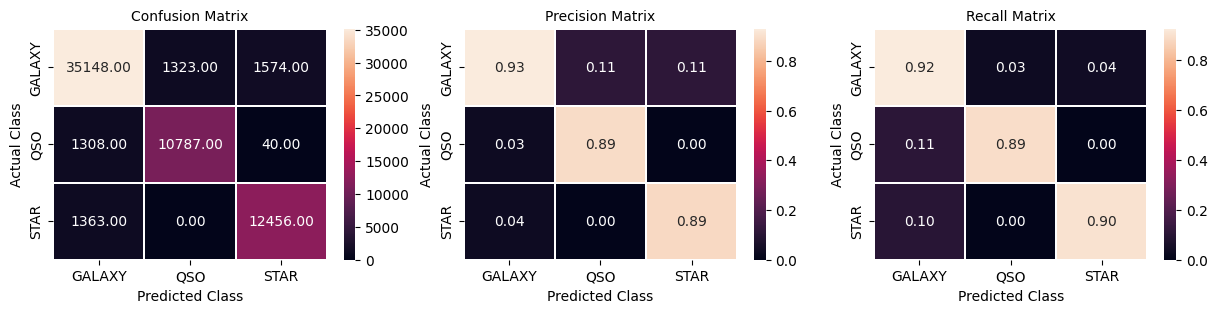

              precision    recall  f1-score   support

      GALAXY       0.93      0.92      0.93     38045
         QSO       0.89      0.89      0.89     12135
        STAR       0.89      0.90      0.89     13819

    accuracy                           0.91     63999
   macro avg       0.90      0.90      0.90     63999
weighted avg       0.91      0.91      0.91     63999

Cross Validation
Logloss (CV): 0.313 for the best C: 0.1
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


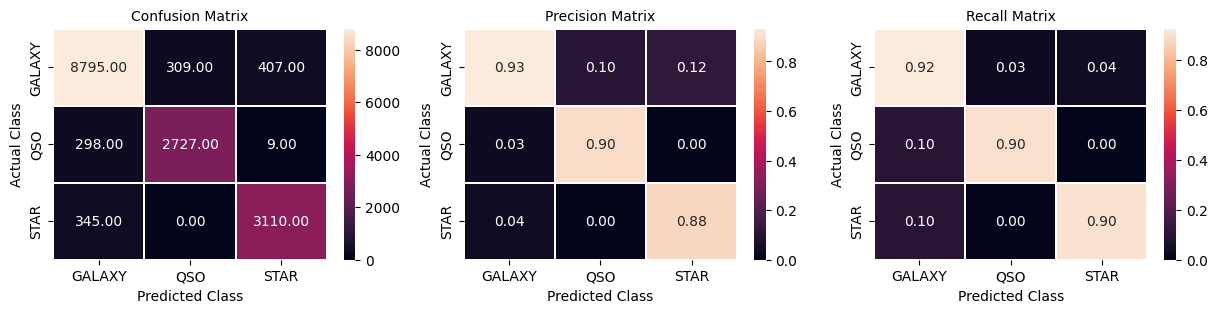

              precision    recall  f1-score   support

      GALAXY       0.93      0.92      0.93      9511
         QSO       0.90      0.90      0.90      3034
        STAR       0.88      0.90      0.89      3455

    accuracy                           0.91     16000
   macro avg       0.90      0.91      0.91     16000
weighted avg       0.91      0.91      0.91     16000

Test
Logloss (Test): 0.318 for the best C: 0.1
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


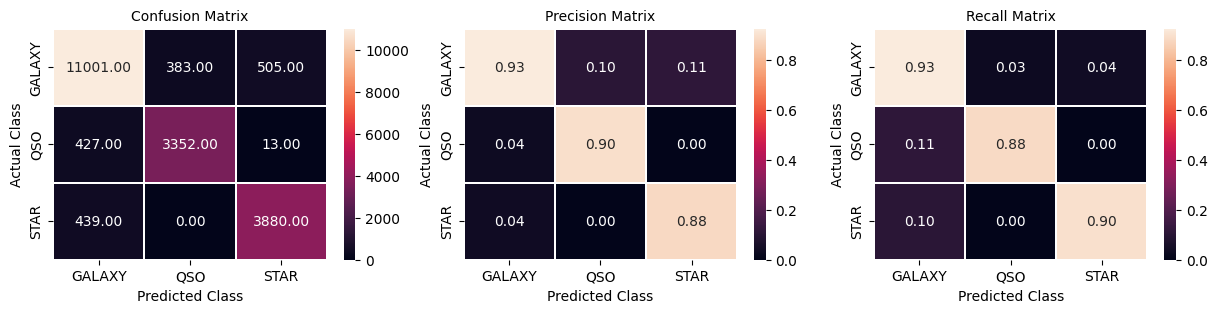

              precision    recall  f1-score   support

      GALAXY       0.93      0.93      0.93     11889
         QSO       0.90      0.88      0.89      3792
        STAR       0.88      0.90      0.89      4319

    accuracy                           0.91     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.91      0.91      0.91     20000



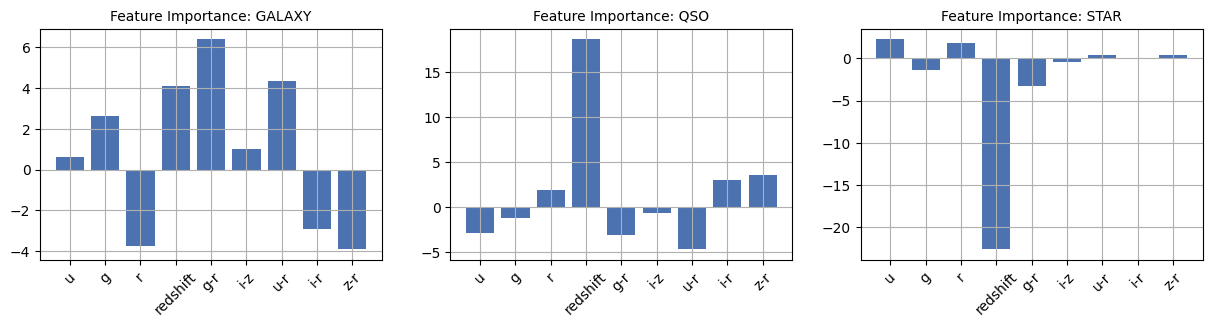

In [63]:
model_name = 'logistic_regression_fea.pkl'

c_params = [10 ** x for x in range(-4, 1)]

(logreg_tr_loss,
 logreg_cv_loss,
 logreg_te_loss) = logistic_regresson(X_train=X_train_fea,
                                      y_train=y_train,
                                      X_cv=X_cv_fea,
                                      y_cv=y_cv,
                                      X_test=X_test_fea,
                                      y_test=y_test,
                                      c_params=c_params,
                                      cols=fea_cols,
                                      model_name=model_name)

4.5.2. Logistic regression on PCA components

Loaded the saved model from the disk.

Train
Logloss (Train): 0.549 for the best C: 0.1
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


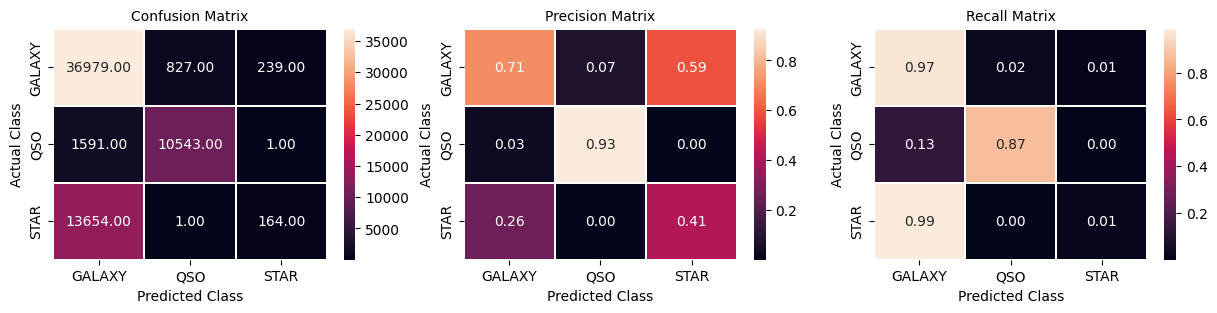

              precision    recall  f1-score   support

      GALAXY       0.71      0.97      0.82     38045
         QSO       0.93      0.87      0.90     12135
        STAR       0.41      0.01      0.02     13819

    accuracy                           0.75     63999
   macro avg       0.68      0.62      0.58     63999
weighted avg       0.68      0.75      0.66     63999

Cross Validation
Logloss (CV): 0.545 for the best C: 0.1
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


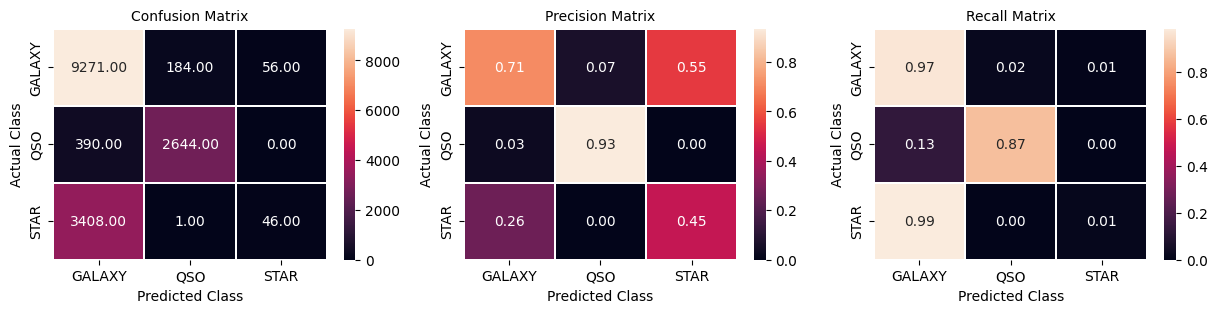

              precision    recall  f1-score   support

      GALAXY       0.71      0.97      0.82      9511
         QSO       0.93      0.87      0.90      3034
        STAR       0.45      0.01      0.03      3455

    accuracy                           0.75     16000
   macro avg       0.70      0.62      0.58     16000
weighted avg       0.70      0.75      0.66     16000

Test
Logloss (Test): 0.551 for the best C: 0.1
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


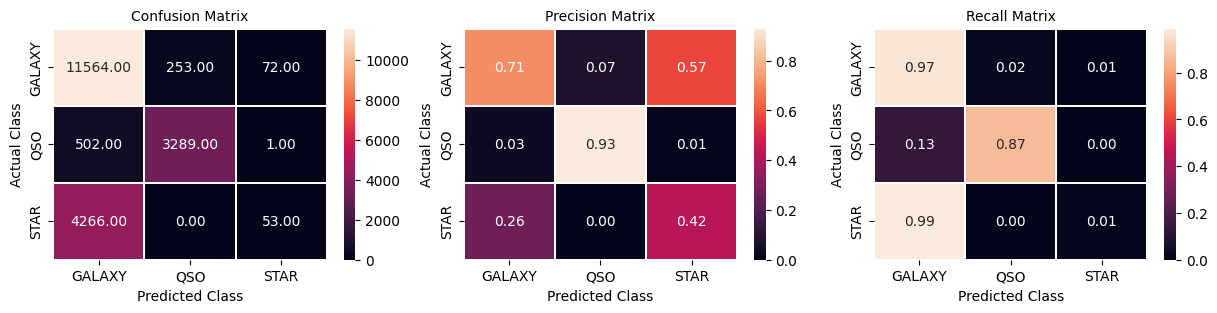

              precision    recall  f1-score   support

      GALAXY       0.71      0.97      0.82     11889
         QSO       0.93      0.87      0.90      3792
        STAR       0.42      0.01      0.02      4319

    accuracy                           0.75     20000
   macro avg       0.69      0.62      0.58     20000
weighted avg       0.69      0.75      0.66     20000



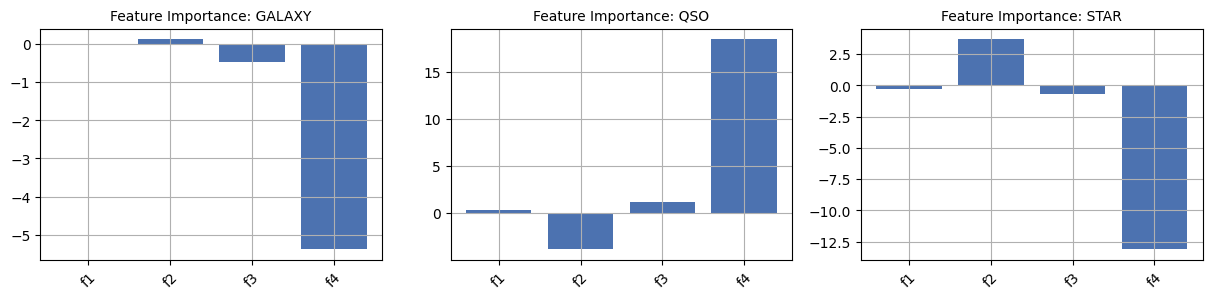

In [64]:
model_name = 'logistic_regression_pca.pkl'

c_params = [10 ** x for x in range(-4, 1)]

(logreg_tr_loss_pca,
 logreg_cv_loss_pca,
 logreg_te_loss_pca) = logistic_regresson(X_train=X_train_pca,
                                          y_train=y_train,
                                          X_cv=X_cv_pca,
                                          y_cv=y_cv,
                                          X_test=X_test_pca,
                                          y_test=y_test,
                                          c_params=c_params,
                                          cols=pca_cols,
                                          model_name=model_name)

4.5.3. Logistic regression on feature-engineered columns and PCA components

In [65]:
train_df_fea_pca = pd.concat(objs=[train_df_fea, train_df_after_pca], axis=1)
cv_df_fea_pca = pd.concat(objs=[cv_df_fea, cv_df_after_pca], axis=1)
test_df_fea_pca = pd.concat(objs=[test_df_fea, test_df_after_pca], axis=1)

In [66]:
fea_pca_cols = fea_cols + pca_cols
print(fea_pca_cols)

['u', 'g', 'r', 'redshift', 'g-r', 'i-z', 'u-r', 'i-r', 'z-r', 'f1', 'f2', 'f3', 'f4']


In [67]:
X_train_fea_pca = train_df_fea_pca[fea_pca_cols].values
X_cv_fea_pca = cv_df_fea_pca[fea_pca_cols].values
X_test_fea_pca = test_df_fea_pca[fea_pca_cols].values

Loaded the saved model from the disk.

Train
Logloss (Train): 0.34 for the best C: 0.1
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


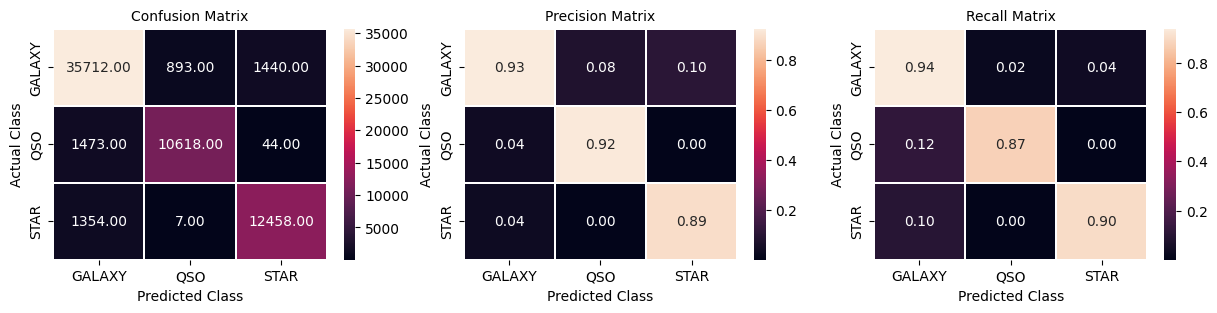

              precision    recall  f1-score   support

      GALAXY       0.93      0.94      0.93     38045
         QSO       0.92      0.87      0.90     12135
        STAR       0.89      0.90      0.90     13819

    accuracy                           0.92     63999
   macro avg       0.91      0.91      0.91     63999
weighted avg       0.92      0.92      0.92     63999

Cross Validation
Logloss (CV): 0.335 for the best C: 0.1
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


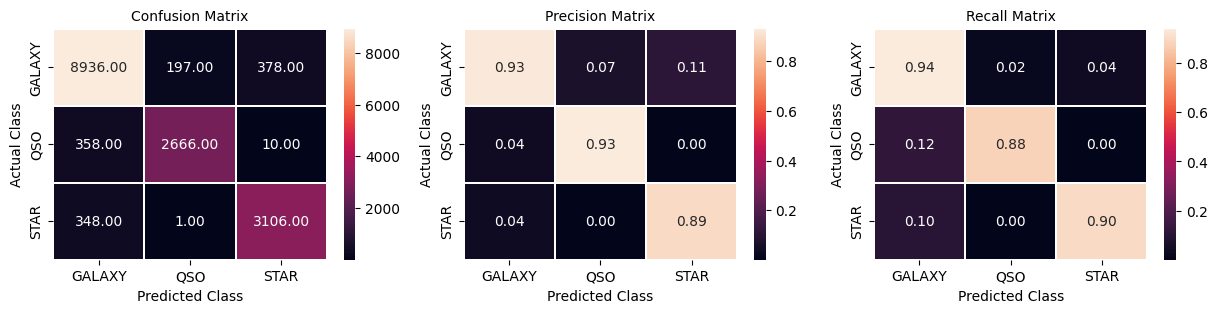

              precision    recall  f1-score   support

      GALAXY       0.93      0.94      0.93      9511
         QSO       0.93      0.88      0.90      3034
        STAR       0.89      0.90      0.89      3455

    accuracy                           0.92     16000
   macro avg       0.92      0.91      0.91     16000
weighted avg       0.92      0.92      0.92     16000

Test
Logloss (Test): 0.342 for the best C: 0.1
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


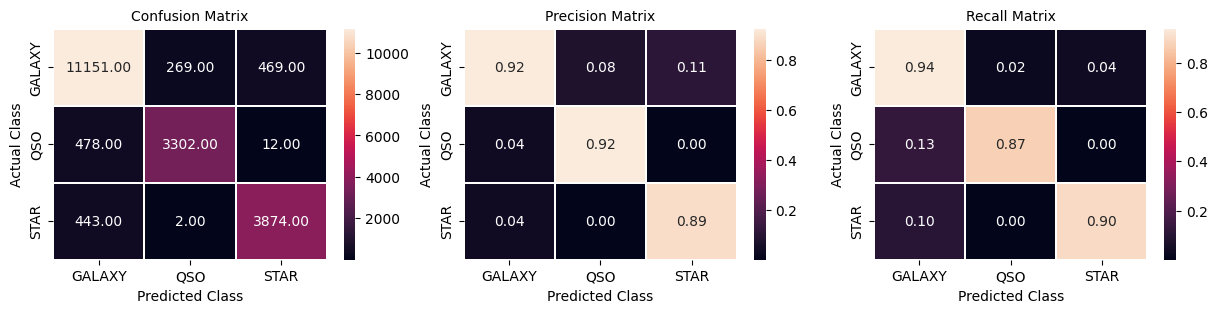

              precision    recall  f1-score   support

      GALAXY       0.92      0.94      0.93     11889
         QSO       0.92      0.87      0.90      3792
        STAR       0.89      0.90      0.89      4319

    accuracy                           0.92     20000
   macro avg       0.91      0.90      0.91     20000
weighted avg       0.92      0.92      0.92     20000



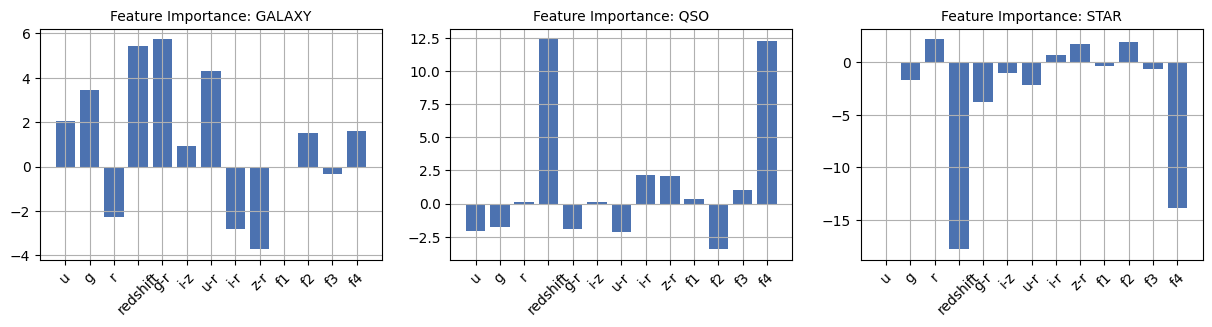

In [68]:
model_name = 'logistic_regression_fea_pca.pkl'

c_params = [10 ** x for x in range(-4, 1)]

(logreg_tr_loss_fea_pca,
 logreg_cv_loss_fea_pca,
 logreg_te_loss_fea_pca) = logistic_regresson(X_train=X_train_fea_pca,
                                              y_train=y_train,
                                              X_cv=X_cv_fea_pca,
                                              y_cv=y_cv,
                                              X_test=X_test_fea_pca,
                                              y_test=y_test,
                                              c_params=c_params,
                                              cols=fea_pca_cols,
                                              model_name=model_name)

__4.6. Conclusion on feature engineering__

I built 3 logistic regression models.

1. Model 1 for only feature-engineered columns. Refer to section 4.5.1.
2. Model 2 for only PCA components. Refer to section 4.5.2.
3. Model 3 for feature-engineered columns and PCA components. Refer to section 4.5.3.

It is clear from the above results that, PCA components are not adding any significance to the performance of logistic regression. Hence, it is good to go with only feature-enginnered columns to modeling the other algorithms.

__4.7. Exporting the data__

In [69]:
def export_data(data, target_arr, filename):
    """
    This function exports the data.
    
    Parameters
    ----------
    `data`: dataframe
    `filename`: the filename that data will be exported to
    """
    if os.path.isdir('./data'):
        pass
    else:
        os.mkdir(path='./data')
    
    data['class'] = target_arr
    data.to_csv(path_or_buf=os.path.join('./data', filename), index=None)
    print("The data is exported to '{}'.".format(filename))

In [70]:
export_data(data=train_df_fea[fea_cols], target_arr=y_train, 
            filename='train_fea.csv')

The data is exported to 'train_fea.csv'.


In [71]:
export_data(data=cv_df_fea[fea_cols], target_arr=y_cv,
            filename='cv_fea.csv')

The data is exported to 'cv_fea.csv'.


In [72]:
export_data(data=test_df_fea[fea_cols], target_arr=y_test,
            filename='test_fea.csv')

The data is exported to 'test_fea.csv'.


In [74]:
export_data(data=test_df_fea[imp_cols], target_arr=y_test,
            filename='test_data.csv')

The data is exported to 'test_data.csv'.


### References {-}

[1] fedesoriano. (January 2022). Stellar Classification Dataset - SDSS17. Retrieved from [here](https://www.kaggle.com/fedesoriano/stellar-classification-dataset-sdss17).

[2] Celestial sphere. (2022, November 21). Wikipedia. [here](https://en.wikipedia.org/wiki/Celestial_sphere).

[3] Celestial equator. (2021, October 30). Wikipedia. [here](https://en.wikipedia.org/wiki/Celestial_equator).

[4] Galactic Sphere, Declination, Right Ascension. (2017, June 17). YouTube. [here](https://youtu.be/TEQb6F6dpRI).

[5] UBV photometric system. (2022, October 13). Wikipedia. [here](https://en.wikipedia.org/wiki/UBV_photometric_system).

[6] Photometric system. (2022, November 18). Wikipedia. [here](https://en.wikipedia.org/wiki/Photometric_system#Photometric_letters).

[7] What is 'red shift'? European Space Agency. [here](https://www.esa.int/Science_Exploration/Space_Science/What_is_red_shift).

[8] Feature engineering. (2022, November 2). Wikipedia. [here](https://en.wikipedia.org/wiki/Feature_engineering).